# Model Training Script

    - This script aims to predict real estate prices per square meter in Paris for the year 2022. It involves data preprocessing, feature engineering, model selection, hyperparameter tuning, and training the best model.

***

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm
import warnings

KeyboardInterrupt: 

### Cleaning and splitting the dataset

In [ ]:
# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")


csv_file_path = 'transactions.csv'
df = pd.read_csv(csv_file_path)

# Check if the column 'Unnamed: 0' exists and drop it
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
# Check for empty columns
empty_cols = df.columns[df.isnull().all()]
if not empty_cols.empty:
    # Remove empty columns
    df = df.drop(empty_cols, axis=1)

# Calculate price per square meter
df['prix_m2'] = df['prix'] / df['surface_habitable']

# List of department numbers for Île-de-France
ile_de_france_departments = [75, 77, 78, 91, 92, 93, 94, 95]

# Filter for transactions in Paris in 2022
paris_df = df[(df.departement.isin(ile_de_france_departments)) & (df.date_transaction.str.startswith('2022-'))].copy()

# Process surface columns
surface_cols = [c for c in paris_df.columns if 'surface_' in c and c != 'surface_habitable']
for c in surface_cols:
    paris_df[c + '_sum'] = paris_df[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)
    
# Filter rows where the sum of surface columns is 0
paris_df = paris_df[paris_df[[c + '_sum' for c in surface_cols]].sum(axis=1) == 0]

# Convert date_transaction to datetime and calculate days since epoch
paris_df['date_transaction'] = pd.to_datetime(paris_df['date_transaction'])
reference_date = pd.to_datetime('1970-01-01')
paris_df['days_since_epoch'] = (paris_df['date_transaction'] - reference_date).dt.days

# Drop the original date_transaction column
paris_df = paris_df.drop('date_transaction', axis=1)

# Create dummy variables for type_batiment
paris_df = pd.get_dummies(paris_df, columns=['type_batiment'], prefix='type')

# Select relevant features for X and y
X = paris_df[['days_since_epoch', 'longitude', 'latitude', 'id_ville', 'type_Appartement', 'type_Maison', 'vefa', 'n_pieces', 'surface_habitable']]
y = paris_df['prix_m2']

# Separate categorical and numerical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# Save the processed DataFrame to a new file
dataset_file_path = 'dataset.csv'
paris_df.to_csv(dataset_file_path, index=False)

dataset_file_path

# Division of the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


### Grid of parameters for the search

In [ ]:

params_grid = {
    'DTR': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': range(1, 101, 10),
            'min_samples_split': range(2, 21, 2)
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': range(1, 51, 5)
        }
    },
    'LR': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        }
    },
    'RFR': {
        'model': RandomForestRegressor(),
        'params': {
            'max_depth': range(71, 89, 4),
            'min_samples_leaf': range(11, 13, 1),
            'n_estimators': [600, 800, 850, 900]
        }
    }
}

### Training of models with cross-validation

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


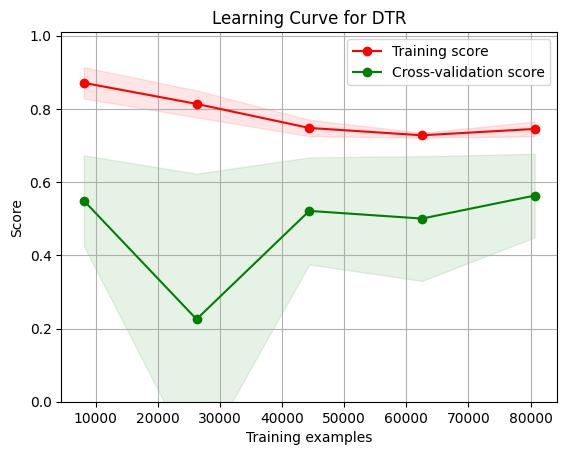

 25%|██▌       | 1/4 [00:23<01:11, 23.97s/it]


Model: DTR
Optimal params: {'max_depth': 11, 'min_samples_split': 4}
Train RMSE: 2140.780288716542
Test RMSE: 3732.1030528930046
Model Score: 0.19066211442391812

Fitting 5 folds for each of 10 candidates, totalling 50 fits


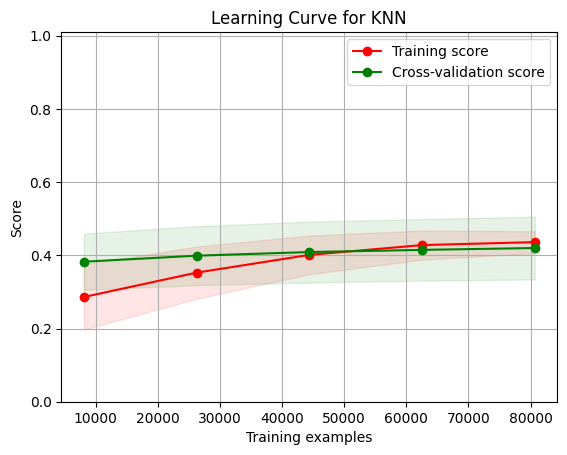

 50%|█████     | 2/4 [00:32<00:29, 14.71s/it]


Model: KNN
Optimal params: {'n_neighbors': 31}
Train RMSE: 3261.4760947122704
Test RMSE: 3093.0278299171177
Model Score: 0.4441081955039846

Fitting 5 folds for each of 4 candidates, totalling 20 fits


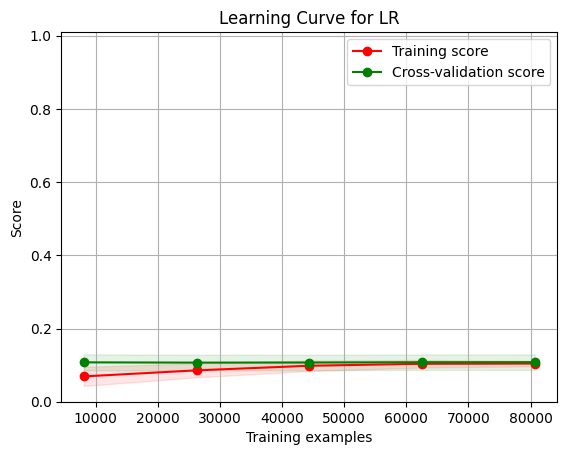

 75%|███████▌  | 3/4 [00:33<00:08,  8.37s/it]


Model: LR
Optimal params: {'fit_intercept': False, 'positive': False}
Train RMSE: 4116.993619825471
Test RMSE: 3899.587480570109
Model Score: 0.11639136590476507

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.01)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Dictionary to store the best models
best_models = {}

# Iterate over each model configuration
for model_name, model_config in tqdm(params_grid.items()):
    # Setting up GridSearchCV with verbosity
    gs = GridSearchCV(estimator=model_config['model'], param_grid=model_config['params'], verbose=3, n_jobs=-1)

    # Fitting the model and plotting learning curve in real-time
    gs.fit(X_train, y_train)
    plot_learning_curve(gs.best_estimator_, X_train, y_train, title=f"Learning Curve for {model_name}", cv=5, n_jobs=-1)

    # Extracting the best model, its parameters, and performance metrics
    best_model = gs.best_estimator_
    best_params = gs.best_params_
    train_rmse = np.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))
    score = best_model.score(X_test, y_test)

    # Saving the best model
    best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'score': score
    }

    # Display of results for each model
    print(f"\nModel: {model_name}")
    print(f"Optimal params: {best_params}")
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
    print(f"Model Score: {score}")
    print()

In [ ]:

best_model_name = max(best_models, key=lambda k: best_models[k]['score'])
best_model_to_train = best_models[best_model_name]['model']

print(f"\nAutomatically training the best found model ({best_model_name}) with the optimal parameters...")
best_model_to_train.fit(X, y)
print("Training complete.")


### Saving the best model

In [ ]:
# Pickling the best model
pickle_file_path = 'best_model.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(best_model_to_train, file)

print(f"Model saved as {pickle_file_path}")